In [1]:
import numpy as np
import matplotlib.pyplot as plt
import kwant
import scipy.sparse.linalg as sla
import scipy.sparse as sp
from scipy.constants import hbar, e, m_e, h
from types import SimpleNamespace
import tinyarray
import time
import sys
import os

# Import (copy) utils

In [2]:
# define pauli matrices
sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])
sigma_z = tinyarray.array([[1, 0], [0, -1]])

lat = kwant.lattice.honeycomb(a = 1.0, norbs=2)
a_lat, b_lat = lat.sublattices

nnn_hoppings_a = (((-1, 0), a_lat, a_lat), ((0, 1), a_lat, a_lat), ((1, -1), a_lat, a_lat))
nnn_hoppings_b = (((1, 0), b_lat, b_lat), ((0, -1), b_lat, b_lat), ((-1, 1), b_lat, b_lat))
nnn_hoppings_all = nnn_hoppings_a + nnn_hoppings_b
lat_neighbors_2 = [kwant.builder.HoppingKind(*hop) for hop in nnn_hoppings_all]

def onstie(site, param):
    x, y = site.pos
    if np.random.rand() < param.p:
        return param.U_imp+ param.m*sigma_0 if site.family == a_lat else -param.m*sigma_0
    else:
        return param.m*sigma_0 if site.family == a_lat else -param.m*sigma_0
def nn_hopping(site1, site2, param):
    x1, y1 = site1.pos
    x2, y2 = site2.pos
    return -1*np.exp(-1j*param.B/2*(x2 - x1)*(y1 + y2))*sigma_0
def nnn_hopping(site1, site2, param):
    x1, y1 = site1.pos
    x2, y2 = site2.pos
    return 1j*param.t_prime*np.exp(-1j*param.B/2*(x2 - x1)*(y1 + y2))*sigma_z


def atan(y, x):
    ans = np.arctan2(y, x)
    if type ( x + 0.0) == type(y+0.0) and type(x+0.0) in [float, np.float64, np.float128, np.float_]:

        if ans < 0: return 2*np.pi + ans
        else: return ans

    elif type(x) == type(y) and type(x) == type(np.array([])) :
        ans[ans < 0] += 2*np.pi
        return ans

    else: raise TypeError("atan is getting neither floats nor arrays")

# define graphene lattices
def create_graphene_hexagonal_system(r, start = 0, a = 1.0, norb = 2, type_ = 'zigzag'):
    lat = kwant.lattice.honeycomb(a = a, norbs=norb)
    a_lat, b_lat = lat.sublattices

    # returns a boolean function which tests whether the vector is inside the regular polygon
    def Regular_Polygon(r, n = 6, start = 0):
        if n < 3: raise RuntimeError("n >= 3")
        # start specifies the first radius starting angle
        def is_inside(point):
            x, y = point
            # y-=1
            if type_ == 'zigzag':y -=1
            else: y += 1
            angle = atan(y, x) - start
            angle %= (2*np.pi/n)
            alpha = (n - 2)/2/n*np.pi
            return np.sqrt(x*x + y*y) < np.sin(alpha)/np.sin(alpha + angle)*r
        return is_inside
    
    # create system
    sys = kwant.Builder()
    sys[lat.shape(Regular_Polygon(r, start=start), (0, 0))] = onstie # onsite energies are set to 0
    sys[lat.neighbors(n=1)] = nn_hopping

    # Choose a specific site

    sites = list(sys.sites())
    # Count the number of connections (hopping terms) for the site
    # make sure that no lattice point is connected to more than one site
    for s in sites:
        num_connections = sum(1 for _ in sys.neighbors(s))
        if num_connections == 1: del sys[s]

    # sys[lat.neighbors(n=2)] = nnn_hopping
    sys[lat_neighbors_2] = nnn_hopping

    return sys

def create_graphene_tiangular_system(r, start = 0, a = 1.0, norb = 2, type_ = 'zigzag'):
    lat = kwant.lattice.honeycomb(a = a, norbs=norb)
    a_lat, b_lat = lat.sublattices
    # returns a boolean function which tests whether the vector is inside the regular polygon
    def Regular_Polygon(r, n = 3, start = 0):
        if n < 3: raise RuntimeError("n >= 3")
        # start specifies the first radius starting angle
        def is_inside(point):
            x, y = point
            # y-=1
            if type_ == 'zigzag':y -=1
            angle = atan(y, x) - start
            angle %= (2*np.pi/n)
            alpha = (n - 2)/2/n*np.pi
            return np.sqrt(x*x + y*y) < np.sin(alpha)/np.sin(alpha + angle)*r
        return is_inside

    # create system
    sys = kwant.Builder()
    sys[lat.shape(Regular_Polygon(r, start=start), (0, 0))] = onstie # onsite energies are set to 0
    sys[lat.neighbors(n=1)] = nn_hopping

    # Choose a specific site
    sites = list(sys.sites())
    # Count the number of connections (hopping terms) for the site
    # make sure that no lattice point is connected to more than one site
    for __ in range(2):
        sites = list(sys.sites())
        for s in sites:
            num_connections = sum(1 for _ in sys.neighbors(s))
            if num_connections == 1 or num_connections == 0: del sys[s]
    
    # sys[lat.neighbors(n=2)] = nnn_hopping
    sys[lat_neighbors_2] = nnn_hopping
    
    return sys

def create_graphene_circular_system(r, a=1.0, norb=2):
    lat = kwant.lattice.honeycomb(a=a, norbs=norb)
    a_lat, b_lat = lat.sublattices
    
    sys = kwant.Builder()
    sys[lat.shape(lambda pos: np.linalg.norm(np.array([*pos])) < r, (0, 0))] = onstie
    sys[lat.neighbors(n=1)] = nn_hopping

    for __ in range(3):
        sites = list(sys.sites())
        for s in sites:
            num_connections = sum(1 for _ in sys.neighbors(s))
            if num_connections == 1 or num_connections == 0: del sys[s]

    # sys[lat.neighbors(n=2)] = nnn_hopping
    sys[lat_neighbors_2] = nnn_hopping

    return sys

def create_graphene_nanoribbon(width, length, a=1.0, norb=1):
    lat = kwant.lattice.honeycomb(a=a, norbs=norb)
    a_lat, b_lat = lat.sublattices

    sys = kwant.Builder()
    sys[lat.shape(lambda pos: abs(pos[1]) < width and abs(pos[0])<length, (0, 0))] = onstie
    sys[lat.neighbors(n=1)] = nn_hopping

    for __ in range(3):
        sites = list(sys.sites())
        for s in sites:
            num_connections = sum(1 for _ in sys.neighbors(s))
            if num_connections == 1 or num_connections == 0: del sys[s]

    sys[lat_neighbors_2] = nnn_hopping
    # sys[lat.neighbors(n=2)] = nnn_hopping
    # attach leads
    sym = kwant.TranslationalSymmetry((-a, 0))
    lead = kwant.Builder(sym)
    lead[lat.shape(lambda pos: abs(pos[1]) < width, (0, 0))] = onstie
    lead[lat.neighbors(n=1)] = nn_hopping
    # lead[lat.neighbors(n=2)] = nnn_hopping
    lead[lat_neighbors_2] = nnn_hopping
    sys.attach_lead(lead)
    sys.attach_lead(lead.reversed())
    return sys

In [3]:
class Hamiltonian:
    def __init__(self, h, norb=1, N=None):
        self.h = h
        if N is None: self.N = h.shape[0]
        else: self.N = N
        self.n_sites = h.shape[0]//norb
        self.sol = None
        self.energies = None
        self.eigenstates = None
        self.norb=norb
    
    def solve(self, k=None, return_eigenvectors=True):
        
        if k is None: k = self.N-2*self.norb
        self.k = k
        self._returned_eigenvectors = return_eigenvectors
        if return_eigenvectors is False:
            self.sol =  [sla.eigsh(self.h, k=k, which='SM', return_eigenvectors=return_eigenvectors)]
        else:
            self.sol =  sla.eigsh(self.h, k=k, which='SM', return_eigenvectors=return_eigenvectors)
    
    def get_eigenvalues(self):
        if self.sol is None: self.solve(return_eigenvectors=False)
        self.eigenenergies_preorb = np.sort(self.sol[0])
        if self.norb > 1:
            self.eigenenergies = np.zeros((self.k//self.norb, self.norb))
            for orb in range(self.norb):
                self.eigenenergies[:, orb] = self.eigenenergies_preorb[orb::self.norb]
        else: self.eigenenergies = self.eigenenergies_preorb
        return self.eigenenergies
    
    def get_eigenstates(self):
        if self._returned_eigenvectors is False: self.solve(return_eigenvectors=True)
        self.eigenstates_preorb = (self.sol[1].T)[np.argsort(self.sol[0])]
        if self.norb > 1:    
            # self.eigenstates = np.zeros((self.k, self.n_sites, self.norb), dtype=complex)
            self.eigenstates = np.zeros((self.k//self.norb, self.n_sites, self.norb), dtype=complex)
            for orb in range(self.norb):
                self.eigenstates[:, :, orb] = self.eigenstates_preorb[::self.norb, orb::self.norb]
        else:
            self.eigenstates = self.eigenstates_preorb
        return self.eigenstates
    
    def get_eigenstate(self, i, orb=None):
        if self.eigenstates is None: self.get_eigenstates()
        if orb is None: return self.eigenstates[i]
        elif orb > self.norb: raise ValueError("orbital index out of range")
        return self.eigenstates[i, :, orb-1]
    
    def zero_energy(self):
        if self.eigenenergies is None: self.get_eigenvalues()
        return np.where(np.allclose(np.abs(self.eigenenergies), 0, rtol=1e-2))[0]
    
    def plot_state(self, system, i):
        if self.eigenstates is None: self.get_eigenstates()
        kwant.plotter.map(sys=system, value=self.eigenstates[i], oversampling=10, cmap='inferno', show=True, dpi=400)
        plt.show()


In [4]:
# calculate the current
def calculate_current(sys, state, param, plot=False, polarized = False, up = None):
    if polarized is True:
        currentz = kwant.operator.Current(sys, sigma_z)
        current0 = kwant.operator.Current(sys, sigma_0)
        if up is None:
            i = currentz(state, params=dict(param = param))
        elif up is True:
            i = (current0(state, params=dict(param = param)) + currentz(state, params=dict(param = param)))/2
        else:
            i = (current0(state, params=dict(param = param)) - currentz(state, params=dict(param = param)))/2
    else: 
        current = kwant.operator.Current(sys, sigma_0)
        i = current(state, params=dict(param=param))
    if plot:
        kwant.plotter.current(sys, i)
        plt.show()
    return i

def calculate_current_2(sys, state_number, param, plot=False, polarized = False, up = None):
    # h = sys.hamiltonian_submatrix(params=dict(param = SimpleNamespace(B=0.0, t_prime=0.05, m=0.0)), sparse=True)
    h = sys.hamiltonian_submatrix(params=dict(param = param), sparse=True)
    N = h.shape[0]
    hamiltonian = Hamiltonian(h, norb=2)
    hamiltonian.solve(return_eigenvectors=True)
    energies = hamiltonian.get_eigenvalues()

    state1 = hamiltonian.get_eigenstate(state_number, orb=1)
    state2 = hamiltonian.get_eigenstate(state_number, orb=2)

    state = np.zeros(N)*0.0j
    state[0::2] = state1
    state[1::2] = state2
    
    if polarized is True:
        currentz = kwant.operator.Current(sys, sigma_z)
        current0 = kwant.operator.Current(sys, sigma_0)
        if up is None:
            i = currentz(state, params=dict(param = param))
        elif up is True:
            i = (current0(state, params=dict(param = param)) + currentz(state, params=dict(param = param)))/2
        else:
            i = (current0(state, params=dict(param = param)) - currentz(state, params=dict(param = param)))/2
    else: 
        current = kwant.operator.Current(sys, sigma_0)
        i = current(state, params=dict(param=param))
    if plot:
        kwant.plotter.current(sys, i)
        plt.show()
    return i

In [5]:
def scatter(arr, sort=True, show=False):
    if sort:
        plt.scatter(range(len(arr)), np.sort(arr))
    else:
        plt.scatter(range(len(arr)), arr)
    plt.grid(True)
    plt.show()

In [6]:
def total_spin_current(sys, parameters,Nedge=15, sym_point = None):
    # I will assume that the system is symmetric around some point
    graph = list(sys.graph)
    if sym_point is None:
        sym_point = np.array([0., 0.])
        for s in sys.sites:
            sym_point += s.pos
        sym_point/=len(sym_point)
    h = sys.hamiltonian_submatrix(params=dict(param=parameters), sparse=True)
    eig_energies, _eig_vecs = sla.eigsh(h, k=2*Nedge, sigma=1e-9)
    eig_vecs = _eig_vecs.T

    def cut(site_to, site_from):
        x0, y0 = sym_point
        xi, yi = site_from.pos
        xf, yf = site_to.pos
        return xf <= x0 and xi > x0 and yi < 0 and yf < 0
    current = kwant.operator.Current(sys, sigma_z, where=cut, sum=True)
    tot_cur = current(eig_vecs[0], eig_vecs[0], params=dict(param=parameters))
    return tot_cur

# Topological treatment of TGQDs

In the previous part we have established the edge states in Graphene quantum dots using tight binding model with Kane-Mele approximation of the spin orbit coupling to realize the QSH states in the triangular graphene quantum dot with edge states, states which were numerically verified to be robust against external factors.

Now we should focus on considering a different more regirous way of identifying the topological protection in edge states

Our main challenge is that topological protection is usually depicted as a gap in the bulks energy bands, and then concluding that the bulk is indeed insulating.
By calculating the Z2 invariant it is provedthat then the edges have to close the energy band in order to change the topological invariant (topological phase transition).

Yet in our case of finite systems, the bulk is not an infinite system, and therefore the energy bands are ill defined. and it is not trivial to separate the edge from the bulk.

In [7]:
triangular_dot = create_graphene_tiangular_system(10, np.pi/2, 1.0, 2, 'zigzag')

In [8]:
h = triangular_dot.finalized().hamiltonian_submatrix(params=dict(param=SimpleNamespace(B=0, m=0, t_prime=0.01, p=0, U_imp=0.2)), sparse=True)

## Spin Orbit Coupling

In [9]:
total_spin_current(triangular_dot.finalized(), SimpleNamespace(B=0, m=0, t_prime=0.1, p=0, U_imp=0.2))

(0.011526977181573623+2.113414247993627e-22j)

In [10]:
currentsB0 = []
socs = np.linspace(0.01, 0.5, 50)
for soc in socs:
    my_params = SimpleNamespace(B=0.0, t_prime=soc, m=0., U_imp=0.01, p=0, t2=0.0)
    currentsB0.append(np.real(total_spin_current(triangular_dot.finalized(), my_params, sym_point=np.array([0, 0]))))

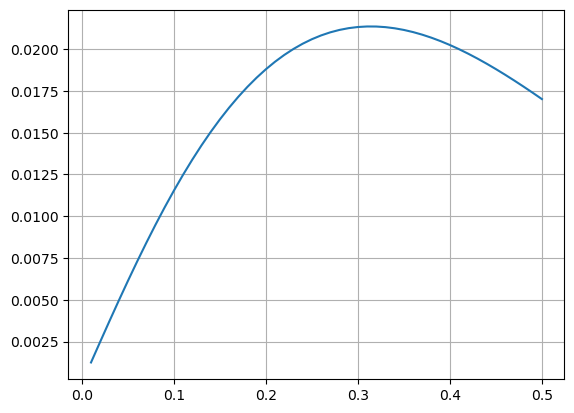

In [11]:
plt.plot(socs, currentsB0)
plt.grid(True)
plt.show()

In [20]:
currentsB01 = []
socs = np.linspace(0.01, 0.5, 50)
for soc in socs:
    my_params = SimpleNamespace(B=0.1, t_prime=soc, m=0., U_imp=0.01, p=0, t2=0.0)
    currentsB01.append(np.real(total_spin_current(triangular_dot.finalized(), my_params, sym_point=np.array([0, 0]))))

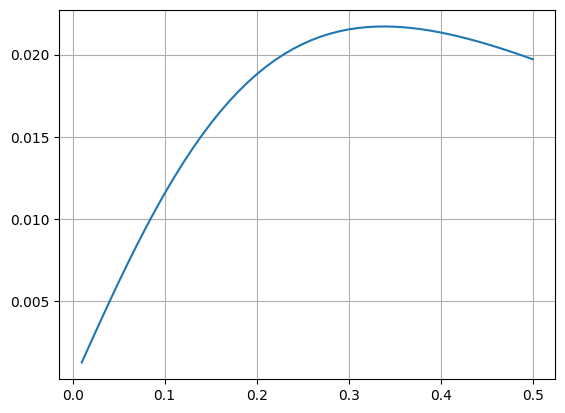

In [21]:
plt.plot(socs, currentsB01)
plt.grid(True)
plt.show()

In [22]:
currentsB05 = []
socs = np.linspace(0.01, 0.5, 50)
for soc in socs:
    my_params = SimpleNamespace(B=0.5, t_prime=soc, m=0., U_imp=0.01, p=0, t2=0.0)
    currentsB05.append(np.real(total_spin_current(triangular_dot.finalized(), my_params, sym_point=np.array([0, 0]))))

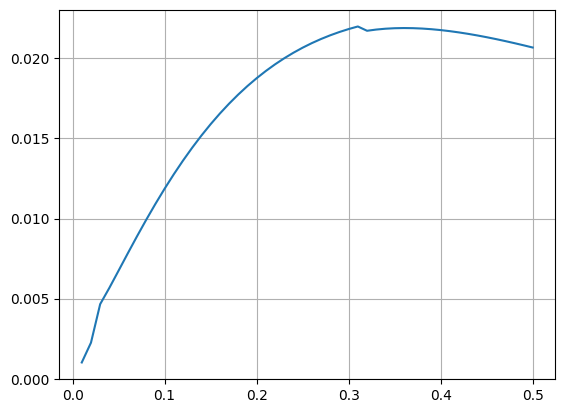

In [23]:
plt.plot(socs, currentsB05)
plt.grid(True)
plt.show()

In [24]:
currentsB10 = []
socs = np.linspace(0.01, 0.5, 50)
for soc in socs:
    my_params = SimpleNamespace(B=1., t_prime=soc, m=0., U_imp=0.01, p=0, t2=0.0)
    currentsB10.append(np.real(total_spin_current(triangular_dot.finalized(), my_params, sym_point=np.array([0, 0]))))

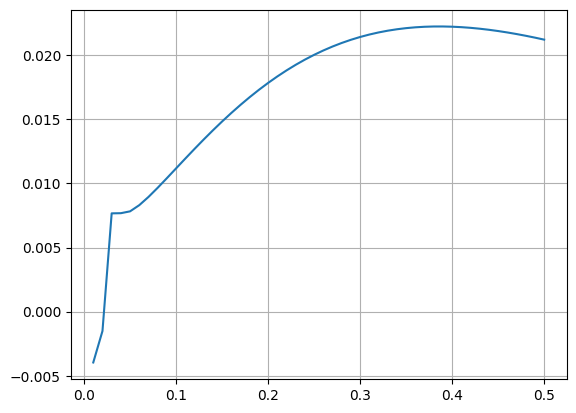

In [25]:
plt.plot(socs, currentsB10)
plt.grid(True)
plt.show()

## Attach leads

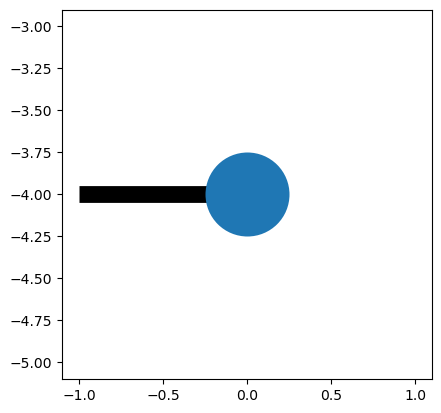

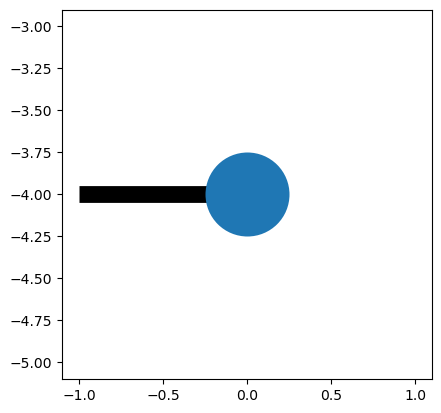

In [12]:
sq_lattice = kwant.lattice.square(a=1.0, norbs=2)
added_site = sq_lattice(-8, -4)
added_site2 = sq_lattice(8, -4)
_lead1 = kwant.Builder(kwant.TranslationalSymmetry([-1, 0]))
_lead1[added_site] = 0*sigma_0
_lead1[sq_lattice.neighbors(1)] = -1*sigma_0

_lead2 = kwant.Builder(kwant.TranslationalSymmetry([1, 0]))
_lead2[added_site2] = 0*sigma_0
_lead2[sq_lattice.neighbors(1)] = -1*sigma_0

kwant.plot(_lead1)
kwant.plot(_lead2)
plt.show()

In [13]:
triangular_dot[added_site] = 0*sigma_0
triangular_dot[added_site2] = 0*sigma_0
triangular_dot[added_site, b_lat(-5, -5)] = -1*sigma_0
triangular_dot[added_site2, b_lat(10, -5)] = -1*sigma_0

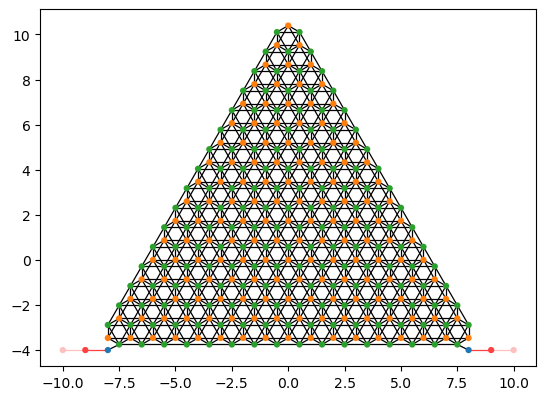

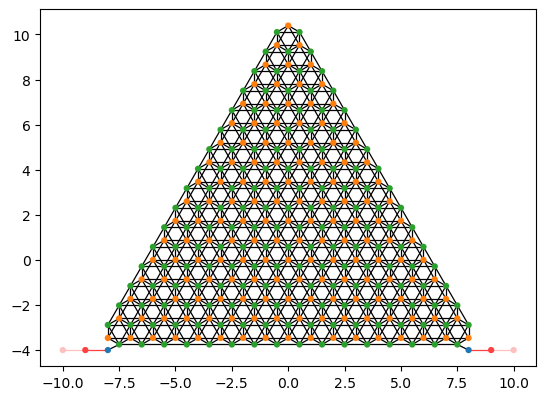

In [14]:
triangular_dot.attach_lead(_lead1)
triangular_dot.attach_lead(_lead2)
kwant.plot(triangular_dot)

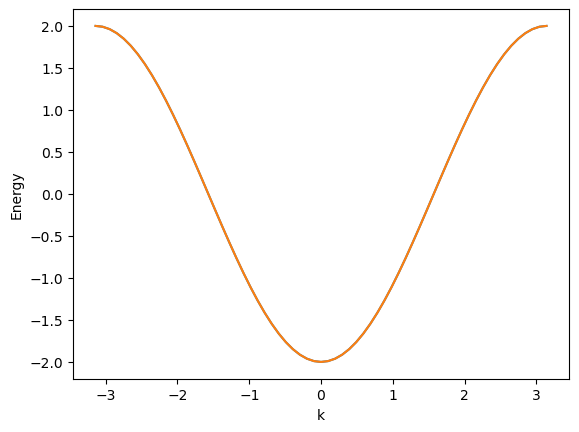

In [15]:
kwant.plotter.bands(triangular_dot.finalized().leads[0])
plt.show()

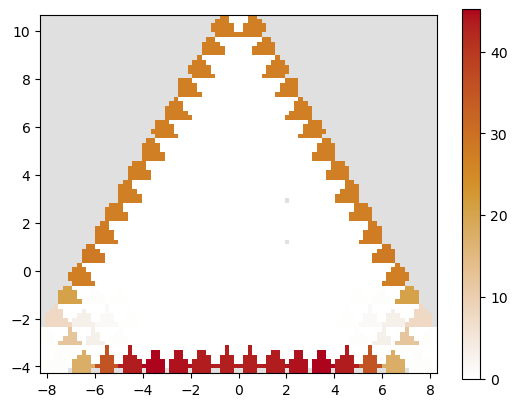

In [40]:
parameters_td = SimpleNamespace(B = 0.0, m=0.0, t_prime=1e-2, t2=0.0, p=0.0, U_imp=0.0)

psi = kwant.wave_function(sys=triangular_dot.finalized(), energy=0.0, params=dict(param=parameters_td))
up = lambda n: psi(n)[:, 0::2]
down = lambda n: psi(n)[:, 1::2]
kwant.plotter.map(triangular_dot.finalized(), np.abs(up(1)[1])**2)
plt.show()

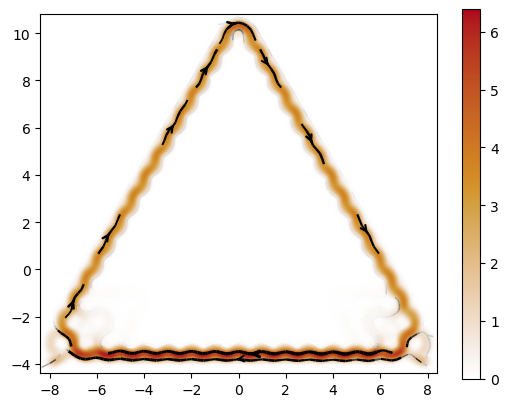

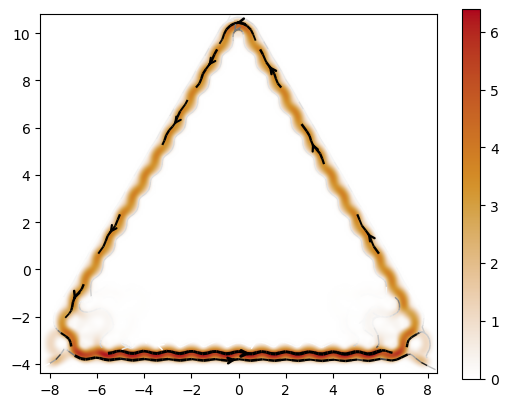

In [43]:
current_z = kwant.operator.Current(triangular_dot.finalized(), sigma_z)
current = kwant.operator.Current(triangular_dot.finalized())
current_arr = current(psi(0)[0], params=dict(param=parameters_td))
spin_current_arr = current_z(psi(0)[0], params=dict(param=parameters_td))
kwant.plotter.current(triangular_dot.finalized(), spin_current_arr)
kwant.plotter.current(triangular_dot.finalized(), current_arr)
plt.show()

## current analysis

In [24]:
energies = np.linspace(-0.5, 0.5, 1000)
currents = []
def cut(site_to, site_from):
    xi, yi = site_from.pos
    xf, yf = site_to.pos
    x0, y0 = 0, 2
    return xi >= x0 and xf < x0 and yi < y0 and yf < y0
op = kwant.operator.Current(triangular_dot.finalized(), sigma_z, where = cut, sum=True)
parameters_td = SimpleNamespace(B = 0.0, m=-0.0, t_prime=0.025, t2=0.0, p=0.0, U_imp=0.3)
for energy in energies:
    psi = kwant.wave_function(triangular_dot.finalized(), energy, params=dict(param=parameters_td))
    currents.append(op(psi(1)[1], params=dict(param=parameters_td)))

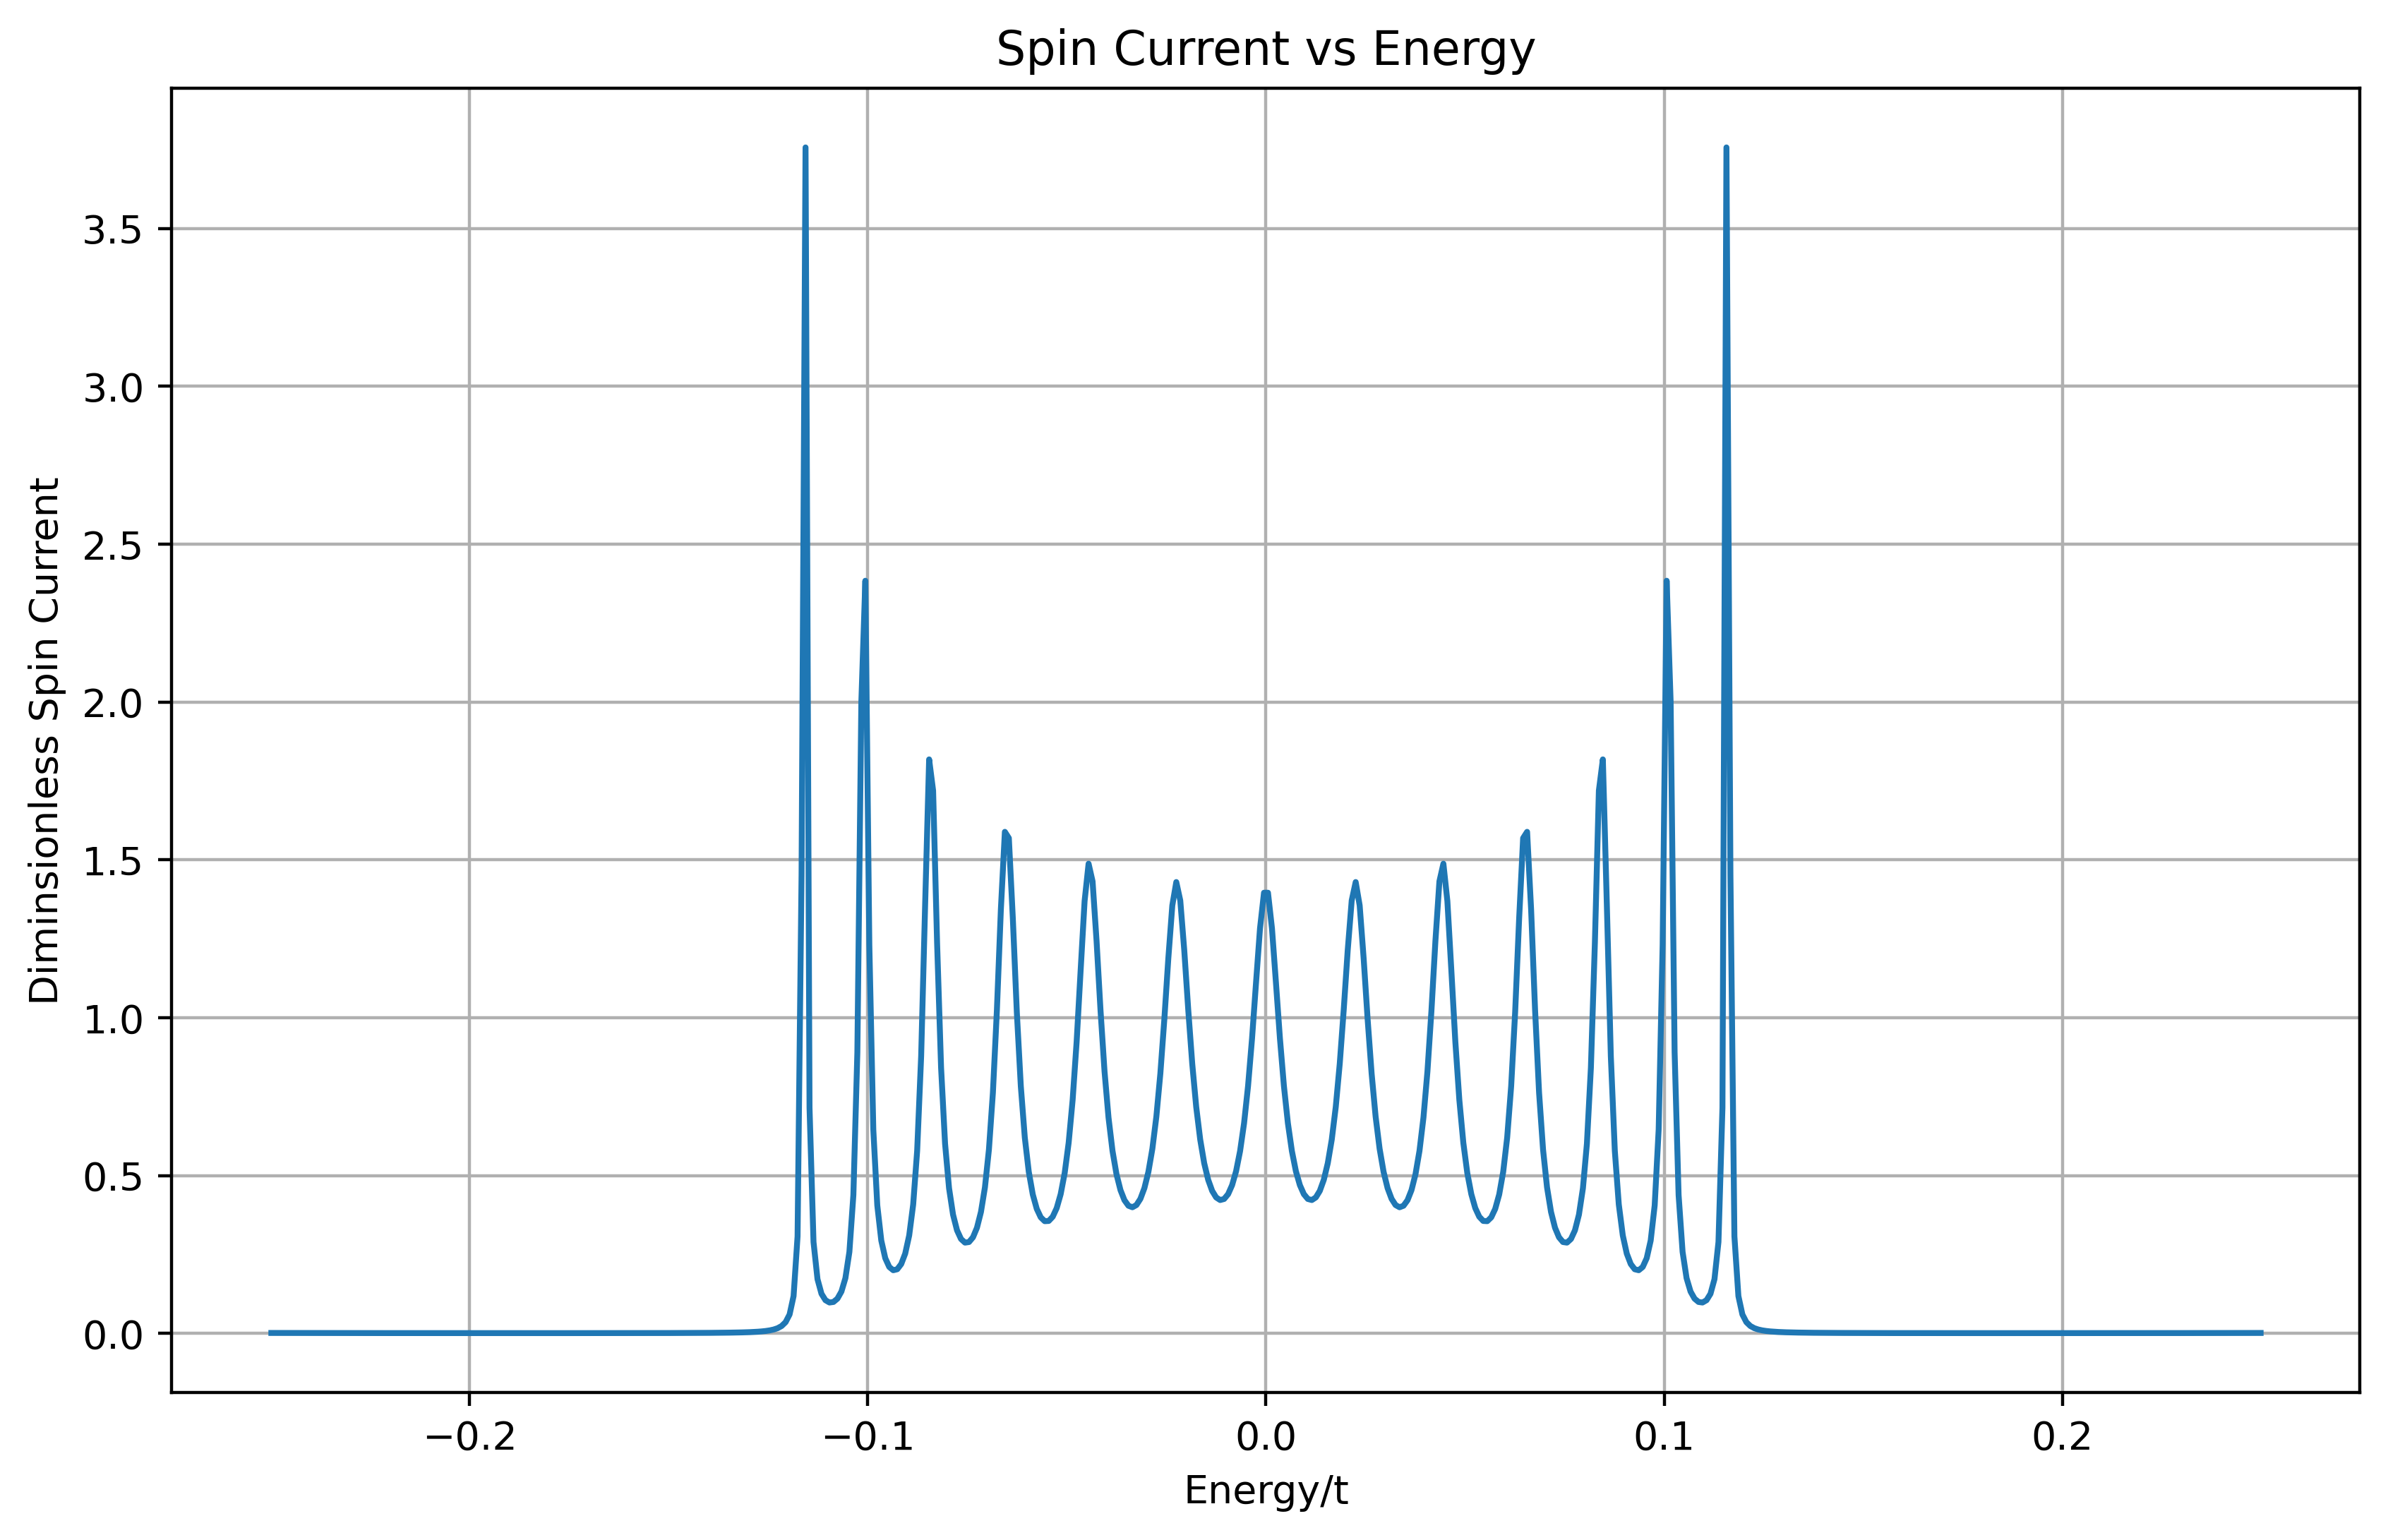

In [27]:
plt.figure(figsize=(10, 6), dpi=400)
plt.title("Spin Current vs Energy")
plt.xlabel("Energy/t")
plt.ylabel("Diminsionless Spin Current")
plt.plot(energies[250:750], currents[250:750])
plt.grid(True)
plt.show()